In [2]:
import shapely
import gmaps
from shapely.geometry import Point, Polygon, box
from matplotlib import pyplot as plt
import numpy as np
import pickle

gmaps.configure(api_key="")

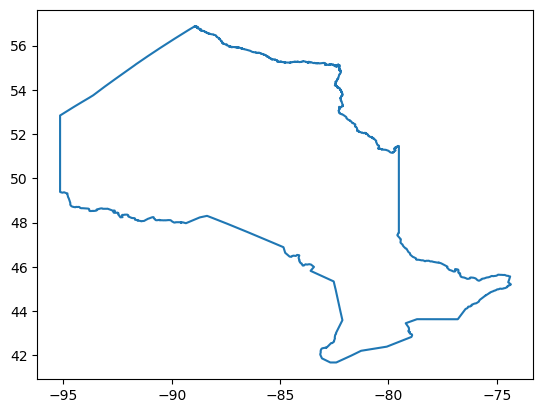

In [3]:
canadaPoly = pickle.load(open("data/pickle/canadaPoly.pkl",'rb'))
canadaPoly = Polygon(canadaPoly)
x, y = canadaPoly.exterior.xy
plt.plot(x,y)

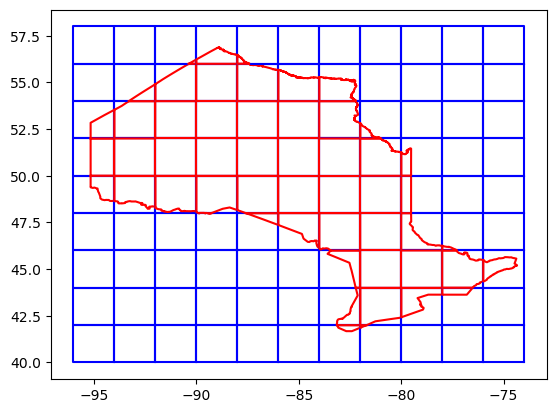

In [4]:
dim = 2
bounds = canadaPoly.bounds
xmin = int(bounds[0] // dim)
xmax = int(bounds[2] // dim)
ymin = int(bounds[1] // dim)
ymax = int(bounds[3] // dim)
for i in range(xmin, xmax+1):
    for j in range(ymin, ymax+1):
        b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
        g = canadaPoly.intersection(b)
        x, y = b.exterior.xy
        plt.plot(x, y, c='b')
        if g.is_empty:
            continue
        if type(g) == shapely.geometry.multipolygon.MultiPolygon:
            for gems in g.geoms:
                x,y = gems.exterior.xy
                plt.plot(x,y,c='r')
        else:
            x, y = g.exterior.xy
            plt.plot(x, y, c='r')
plt.show()

In [5]:
def partition(polygon, dim, mergeFactor=0.1):
    '''
    polygon: Unsplit polygon of mainland US
    dim: The dimensions of each grid to split the map into
    mergeFactor: threshold of smallest grid. 
    Any grid smaller will be combined with neighbouring grids
    '''
    bounds = polygon.bounds
    xmin = int(bounds[0] // dim)
    xmax = int(bounds[2] // dim)
    ymin = int(bounds[1] // dim)
    ymax = int(bounds[3] // dim)
    grid = 0
    res = []
    for i in range(xmin, xmax+1):
        for j in range(ymin, ymax+1):
            b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
            g = polygon.intersection(b)
            if g.is_empty:
                continue
            if type(g)==shapely.geometry.multipolygon.MultiPolygon:
                for gems in g.geoms:
                    res.append(gems)
                    grid += 1
            else:
                res.append(g)
                grid += 1
    return merge(res, mergeFactor)

def merge(polyList, mergeFactor=0.1):
    '''
    polyList: list of polygon grids the map is split into
    mergeFactor: threshold of smallest grid. 
    Any grid smaller will be combined with neighbouring grids
    '''
    def combine(pidx, polyL):
        p = polyL[pidx]
        del polyL[pidx]
        for idx,i in enumerate(polyL):
            u = p.union(i)
            if p.intersects(i) and type(u)!=shapely.geometry.multipolygon.MultiPolygon:
                polyL[idx] = u
                break
        return polyL
    
    mnLimit = max(polyList, key=lambda x:x.area).area * mergeFactor
    mnPoly = min(polyList, key=lambda x:x.area)
    while mnPoly.area <= mnLimit:
        polyList = combine(polyList.index(mnPoly), polyList)
        mnPoly = min(polyList, key=lambda x:x.area)
        
    result = {}
    for idx, i in enumerate(polyList):
        x,y = i.exterior.xy
        result[idx] = np.array([(y,x) for x, y in zip(x,y)])
    return result

def plotMap(polyGrid):
    gPoly = []
    gMarkLoc = []
    gMarkInf = []
    info_box_template = """
    <dl>
    <dd>{}</dd>
    </dl>
    """
    for k, v in polyGrid.items():
        gPoly.append(gmaps.Polygon(
                        list(v),
                        stroke_color='red',
                        fill_color='blue'
                        ))
        gMarkLoc.append((v[0][0], v[0][1]))
        gMarkInf.append(info_box_template.format(k))
    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
#     fig.add_layer(gmaps.marker_layer(gMarkLoc, info_box_content=gMarkInf))
    return fig

In [6]:
canadaPolyGrid = partition(canadaPoly, 2, mergeFactor=0.1)

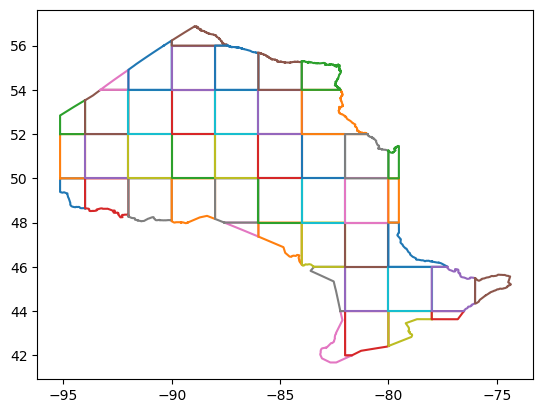

Number of polygons: 46


In [7]:
for i in canadaPolyGrid.values():
    plt.plot(i[:,1], i[:,0])
plt.show()
print("Number of polygons:", len(canadaPolyGrid))

In [10]:
plotMap(canadaPolyGrid)

Figure(layout=FigureLayout(height='420px'))

In [9]:
pickle.dump(canadaPolyGrid, open("data/pickle/canadaPolyGrid.pkl", "wb"))